In [1]:
import pandas as pd
from collections import Counter
import re
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt
pio.templates.default = "plotly_white"

queries_df = pd.read_csv("/content/search_query_anomaly.csv")
print(queries_df.head())

                                 Top queries  Clicks  Impressions     CTR  \
0                number guessing game python    5223        14578  35.83%   
1                        thecleverprogrammer    2809         3456  81.28%   
2           python projects with source code    2077        73380   2.83%   
3  classification report in machine learning    2012         4959  40.57%   
4                      the clever programmer    1931         2528  76.38%   

   Position  
0      1.61  
1      1.02  
2      5.94  
3      1.28  
4      1.09  


In [2]:
print(queries_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Top queries  1000 non-null   object 
 1   Clicks       1000 non-null   int64  
 2   Impressions  1000 non-null   int64  
 3   CTR          1000 non-null   object 
 4   Position     1000 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB
None


In [3]:
# Cleaning CTR column
queries_df['CTR'] = queries_df['CTR'].str.rstrip('%').astype('float') / 100

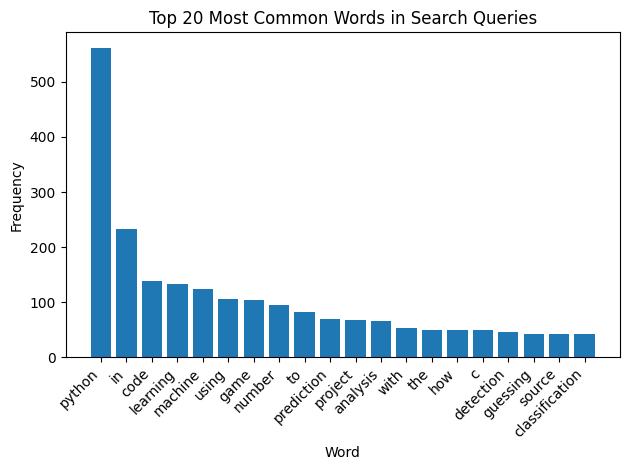

In [4]:
# Function to clean and split the queries into words
def clean_and_split(query):
    words = re.findall(r'\b[a-zA-Z]+\b', query.lower())
    return words

# Split each query into words and count the frequency of each word
word_counts = Counter()
for query in queries_df['Top queries']:
    word_counts.update(clean_and_split(query))

word_freq_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Plotting the word frequencies
plt.bar(word_freq_df['Word'], word_freq_df['Frequency'])
plt.title('Top 20 Most Common Words in Search Queries')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

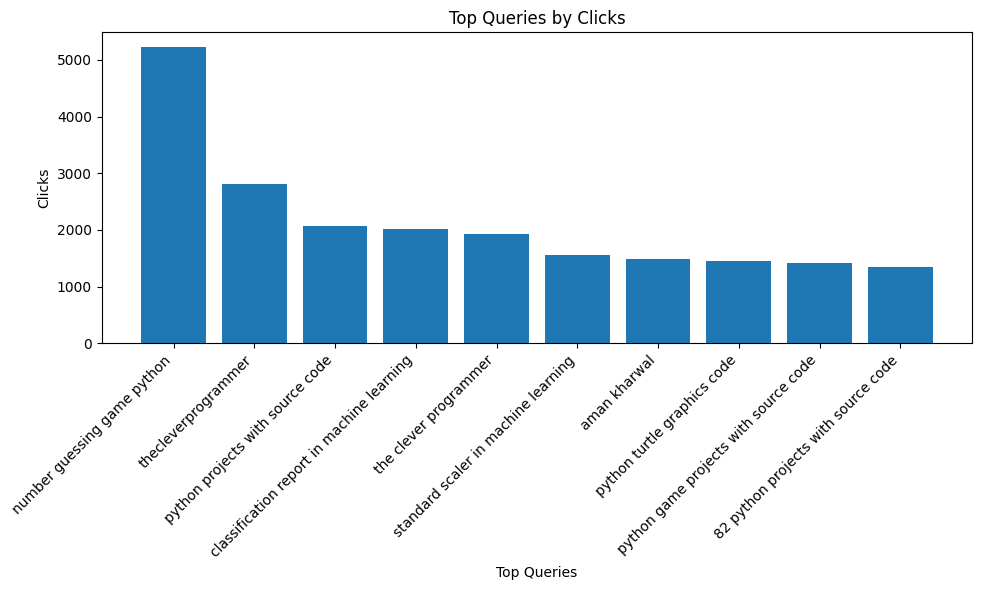

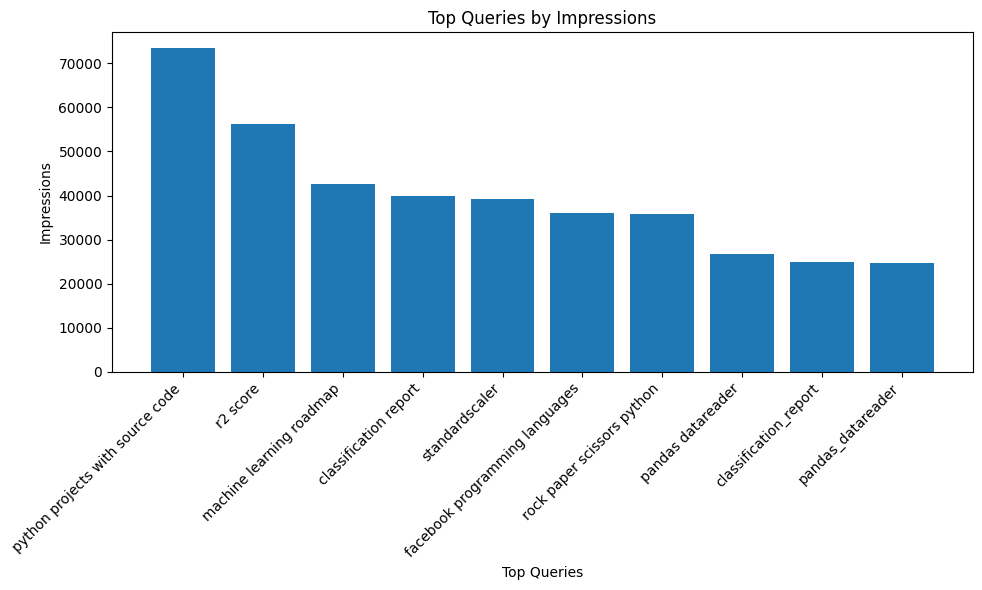

In [5]:
# Top queries by Clicks and Impressions
top_queries_clicks_vis = queries_df.nlargest(10, 'Clicks')[['Top queries', 'Clicks']]
top_queries_impressions_vis = queries_df.nlargest(10, 'Impressions')[['Top queries', 'Impressions']]

# Plot for Clicks
plt.figure(figsize=(10, 6))
plt.bar(top_queries_clicks_vis['Top queries'], top_queries_clicks_vis['Clicks'])
plt.title('Top Queries by Clicks')
plt.xlabel('Top Queries')
plt.ylabel('Clicks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot for Impressions
plt.figure(figsize=(10, 6))
plt.bar(top_queries_impressions_vis['Top queries'], top_queries_impressions_vis['Impressions'])
plt.title('Top Queries by Impressions')
plt.xlabel('Top Queries')
plt.ylabel('Impressions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

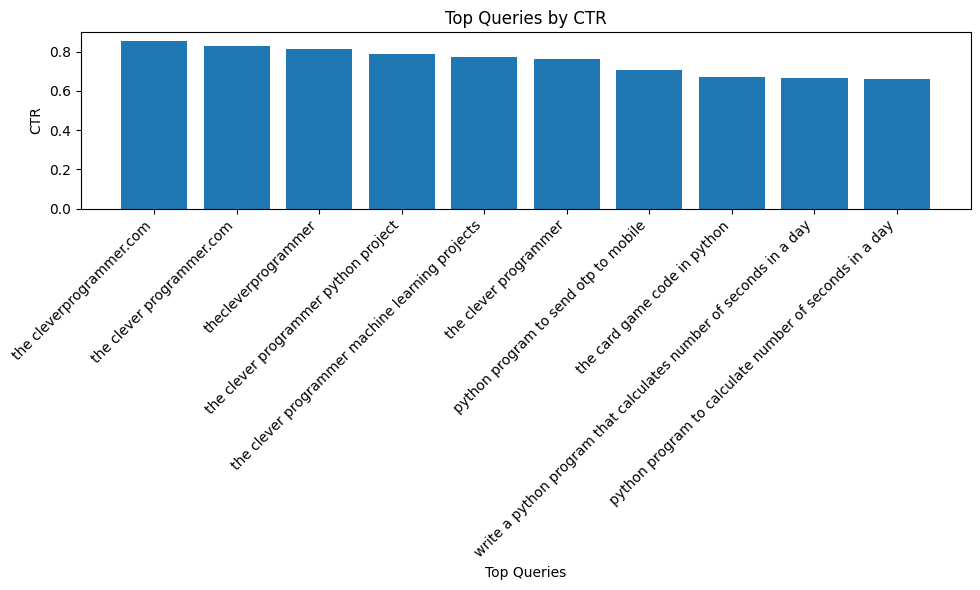

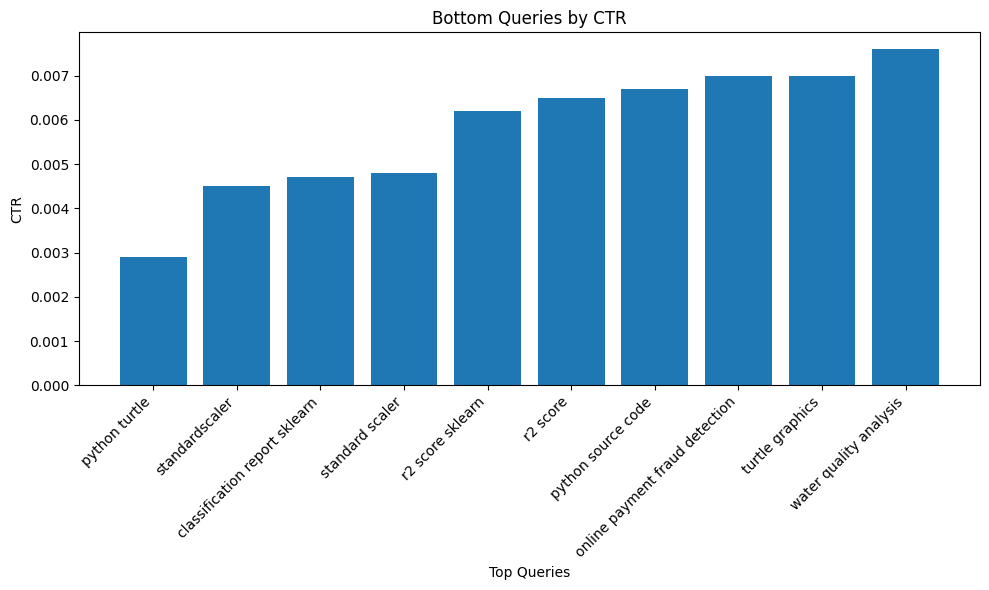

In [6]:
# Queries with highest and lowest CTR
top_ctr_vis = queries_df.nlargest(10, 'CTR')[['Top queries', 'CTR']]
bottom_ctr_vis = queries_df.nsmallest(10, 'CTR')[['Top queries', 'CTR']]

# Plot for Top CTR
plt.figure(figsize=(10, 6))
plt.bar(top_ctr_vis['Top queries'], top_ctr_vis['CTR'])
plt.title('Top Queries by CTR')
plt.xlabel('Top Queries')
plt.ylabel('CTR')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot for Bottom CTR
plt.figure(figsize=(10, 6))
plt.bar(bottom_ctr_vis['Top queries'], bottom_ctr_vis['CTR'])
plt.title('Bottom Queries by CTR')
plt.xlabel('Top Queries')
plt.ylabel('CTR')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


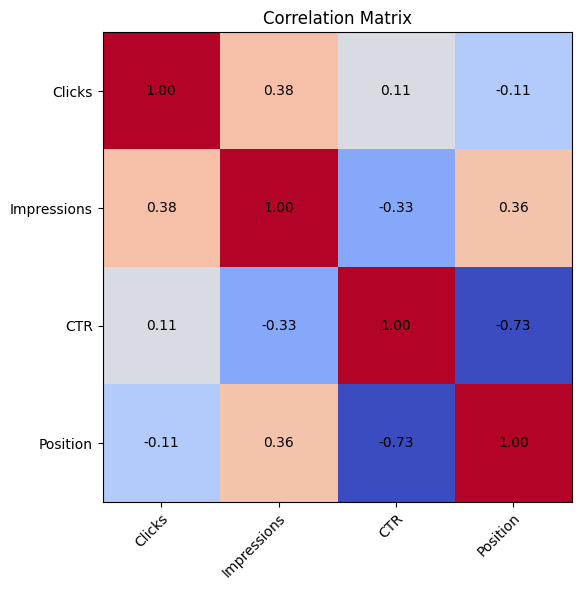

In [7]:
# Correlation matrix visualization
correlation_matrix = queries_df[['Clicks', 'Impressions', 'CTR', 'Position']].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(correlation_matrix, cmap='coolwarm')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        value = correlation_matrix.iloc[i, j]
        ax.text(j, i, f"{value:.2f}",ha="center", va="center", color="black")


ax.set_title('Correlation Matrix')
ax.set_xticks(range(correlation_matrix.shape[1]))
ax.set_yticks(range(correlation_matrix.shape[0]))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
plt.show()

In [8]:
from sklearn.ensemble import IsolationForest

features = queries_df[['Clicks', 'Impressions', 'CTR', 'Position']]

iso_forest = IsolationForest(n_estimators=100, contamination=0.01)  # contamination is the expected proportion of outliers

iso_forest.fit(features)

queries_df['anomaly'] = iso_forest.predict(features)

anomalies = queries_df[queries_df['anomaly'] == -1]

In [9]:
print(anomalies[['Top queries', 'Clicks', 'Impressions', 'CTR', 'Position']])

                          Top queries  Clicks  Impressions     CTR  Position
0         number guessing game python    5223        14578  0.3583      1.61
1                 thecleverprogrammer    2809         3456  0.8128      1.02
2    python projects with source code    2077        73380  0.0283      5.94
4               the clever programmer    1931         2528  0.7638      1.09
15         rock paper scissors python    1111        35824  0.0310      7.19
21              classification report     933        39896  0.0234      7.53
34           machine learning roadmap     708        42715  0.0166      8.97
82                           r2 score     367        56322  0.0065      9.33
91     facebook programming languages     346        36055  0.0096      1.58
929                     python turtle      52        18228  0.0029     18.75


In [10]:
from sklearn.cluster import KMeans

features = queries_df[['Clicks', 'Impressions', 'CTR', 'Position']]

kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(features)

queries_df['cluster'] = kmeans.labels_


In [11]:
# Group the DataFrame by the new 'cluster' column
cluster_summary = queries_df.groupby('cluster')[['Clicks', 'Impressions', 'CTR', 'Position']].describe()
print(cluster_summary)

        Clicks                                                                \
         count        mean         std    min    25%    50%      75%     max   
cluster                                                                        
0        961.0  155.617066  210.960445   48.0   64.0   91.0   157.00  2809.0   
1         32.0  531.500000  921.626823   52.0  115.0  305.0   495.25  5223.0   
2          7.0  817.000000  649.783810  177.0  356.5  708.0  1022.00  2077.0   

        Impressions                ...      CTR         Position            \
              count          mean  ...      75%     max    count      mean   
cluster                            ...                                       
0             961.0   1196.543184  ...  0.34570  0.8548    961.0  3.806951   
1              32.0  14566.531250  ...  0.03665  0.3583     32.0  8.646250   
2               7.0  46208.428571  ...  0.02585  0.0310      7.0  7.252857   

                                                  

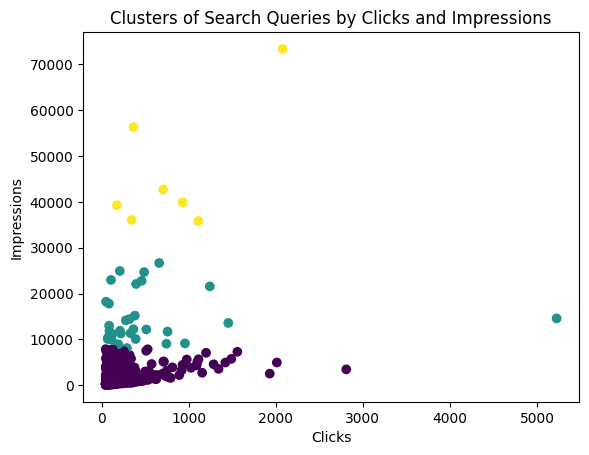

In [12]:
plt.scatter(queries_df['Clicks'], queries_df['Impressions'], c=queries_df['cluster'])
plt.title('Clusters of Search Queries by Clicks and Impressions')
plt.xlabel('Clicks')
plt.ylabel('Impressions')
plt.show()

In [13]:
# Displaying queries belonging to a specific cluster
print(queries_df[queries_df['cluster'] == 0].head())

                                 Top queries  Clicks  Impressions     CTR  \
1                        thecleverprogrammer    2809         3456  0.8128   
3  classification report in machine learning    2012         4959  0.4057   
4                      the clever programmer    1931         2528  0.7638   
5        standard scaler in machine learning    1559         7292  0.2138   
6                               aman kharwal    1490         5752  0.2590   

   Position  anomaly  cluster  
1      1.02       -1        0  
3      1.28        1        0  
4      1.09       -1        0  
5      1.53        1        0  
6      3.75        1        0  


In [14]:
print(queries_df[queries_df['cluster'] == 1].head())

                    Top queries  Clicks  Impressions     CTR  Position  \
0   number guessing game python    5223        14578  0.3583      1.61   
7   python turtle graphics code    1455        13585  0.1071      4.60   
11            clever programmer    1243        21566  0.0576      4.82   
20       hangman game in python     958         9120  0.1050      5.48   
28       house price prediction     758        11695  0.0648      6.93   

    anomaly  cluster  
0        -1        1  
7         1        1  
11        1        1  
20        1        1  
28        1        1  


In [15]:
print(queries_df[queries_df['cluster'] == 2].head())

                         Top queries  Clicks  Impressions     CTR  Position  \
2   python projects with source code    2077        73380  0.0283      5.94   
15        rock paper scissors python    1111        35824  0.0310      7.19   
21             classification report     933        39896  0.0234      7.53   
34          machine learning roadmap     708        42715  0.0166      8.97   
82                          r2 score     367        56322  0.0065      9.33   

    anomaly  cluster  
2        -1        2  
15       -1        2  
21       -1        2  
34       -1        2  
82       -1        2  
